# Main

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

URL transformed to HTTPS due to an HSTS policy
--2025-11-21 21:11:35--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  10.9MB/s    in 23s     

2025-11-21 21:11:59 (10.1 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace tiny-imagenet-200/wnids.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace tiny-imagenet-200/wnids.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

1. Setup and Imports

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time

2. TinyImageNet Dataset Class

In [ ]:
class TinyImageNetDataset(Dataset):
    """
    Custom Dataset class for loading Tiny ImageNet data (train and validation splits).
    Handles reading the directory structure for 'train' and the annotation file for 'val'.
    """
    def __init__(self, root, split="train", transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.samples = []
        self.labels = []
        self.class_to_idx = {}

        if split == "train":
            self.data_dir = os.path.join(root, "train")

            # Map class folders (e.g., 'n01443537') to a simple index (0-199)
            classes = sorted(os.listdir(self.data_dir))
            for idx, cls in enumerate(classes):
                self.class_to_idx[cls] = idx
                img_dir = os.path.join(self.data_dir, cls, "images")
                if os.path.exists(img_dir):
                    for img in os.listdir(img_dir):
                        self.samples.append(os.path.join(img_dir, img))
                        self.labels.append(idx)

        elif split == "val":
            self.data_dir = os.path.join(root, "val", "images")
            ann_file = os.path.join(root, "val", "val_annotations.txt")
            ann_dict = {}

            # Read annotations to get class labels for validation images
            if os.path.exists(ann_file):
                with open(ann_file, "r") as f:
                    for line in f:
                        parts = line.split("\t")
                        ann_dict[parts[0]] = parts[1]

            # Re-create class_to_idx mapping based on validation labels
            classes = sorted(list(set(ann_dict.values())))
            self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

            if os.path.exists(self.data_dir):
                for img in os.listdir(self.data_dir):
                    if img in ann_dict:
                        cls = ann_dict[img]
                        self.samples.append(os.path.join(self.data_dir, img))
                        self.labels.append(self.class_to_idx[cls])

        else:
            raise ValueError("split must be 'train' or 'val'.")

        if not self.samples:
            print(f"Warning: No samples found for split '{split}'. Check data path: {root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Handle grayscale images by converting them to RGB
        img = Image.open(self.samples[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


3. Data Loading and Feature Extraction Setup

In [ ]:
data_path = "/content/tiny-imagenet-200"

# Standard normalization is usually required for ResNet, but here we only use ToTensor
# and Resize as we're using features for clustering/retrieval, not fine-tuning.
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

try:
    train_dataset = TinyImageNetDataset(root=data_path, split="train", transform=transform)
    # Use a batch size that fits memory (128 is a good starting point)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
except FileNotFoundError as e:
    print(f"ERROR: Dataset not found at {data_path}. Please ensure the download/unzip steps are run.")
    print(e)
    # Exit or use dummy data if the environment doesn't allow re-downloading/unzipping.
    # For now, we assume the initial download/unzip in the notebook ran successfully.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Identity()    # remove classifier
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

4. Feature Extraction

In [ ]:
print("Starting feature extraction...")
start_time = time.time()

all_embeddings = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        feats = model(images)
        all_embeddings.append(feats.cpu().numpy())
        all_labels.extend(labels.numpy())

all_embeddings = np.vstack(all_embeddings)
all_labels = np.array(all_labels)

end_time = time.time()
print(f"Feature extraction complete. Shape: {all_embeddings.shape}")
print(f"Time taken: {end_time - start_time:.2f} seconds.")


Starting feature extraction...
Feature extraction complete. Shape: (100000, 2048)
Time taken: 80.82 seconds.


5. OPTIMIZATION: PCA Dimensionality Reduction

In [ ]:
# Use PCA to reduce the high-dimensionality (2048D) for faster clustering/retrieval.
# This is crucial for performance.
PCA_COMPONENTS = 512

print(f"\nOptimization: Applying PCA to reduce features from 2048D to {PCA_COMPONENTS}D...")
pca_start_time = time.time()
# Initialize PCA and fit it on the full 2048D embeddings
pca_model = PCA(n_components=PCA_COMPONENTS, random_state=42)
embeddings_for_clustering = pca_model.fit_transform(all_embeddings)
print(f"PCA complete in {time.time() - pca_start_time:.2f} seconds.")
print(f"New feature shape: {embeddings_for_clustering.shape}")


Optimization: Applying PCA to reduce features from 2048D to 512D...
PCA complete in 32.91 seconds.
New feature shape: (100000, 512)


6. Clustering (K-Means) and Evaluation

In [ ]:
k = 200    # Number of clusters
print(f"\nPerforming MiniBatchKMeans clustering with k={k} on {embeddings_for_clustering.shape[1]}D features...")
start_time = time.time()

# MiniBatchKMeans for massive speed increase over KMeans
kmeans = MiniBatchKMeans(
    n_clusters=k,
    random_state=42,
    batch_size=256,
    n_init=10,
    max_no_improvement=10,
    verbose=0
)
cluster_labels = kmeans.fit_predict(embeddings_for_clustering)

print(f"MiniBatchKMeans Clustering complete in {time.time() - start_time:.2f} seconds.")


Performing MiniBatchKMeans clustering with k=200 on 512D features...
MiniBatchKMeans Clustering complete in 4.90 seconds.


Calculate and print clustering quality metrics (on the PCA-reduced data)

In [ ]:
metric_start_time = time.time()
silhouette = silhouette_score(embeddings_for_clustering, cluster_labels)
db_score = davies_bouldin_score(embeddings_for_clustering, cluster_labels)

print(f"Metrics calculated in {time.time() - metric_start_time:.2f} seconds.")
print(f"Clustering Evaluation:")
print(f"  > Silhouette Score: {silhouette:.4f} (Closer to 1 is better)")
print(f"  > Davies-Bouldin Score: {db_score:.4f} (Closer to 0 is better)")

Metrics calculated in 301.74 seconds.
Clustering Evaluation:
  > Silhouette Score: 0.0274 (Closer to 1 is better)
  > Davies-Bouldin Score: 3.1534 (Closer to 0 is better)


7. Retrieval System Setup (K-Nearest Neighbors)

In [ ]:
nn_model = NearestNeighbors(n_neighbors=6, metric="euclidean")
nn_model.fit(embeddings_for_clustering)

def extract_features_and_pca(img_path):
    """Extracts ResNet-50 features (2048D) and applies the pre-fitted PCA model (512D)."""
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat_2048d = model(img).cpu().numpy()

    # CRITICAL: Apply the same PCA transformation
    feat_512d = pca_model.transform(feat_2048d)

    return feat_512d

def find_similar_images(img_path, top_k=5):
    """Finds similar images in the database for a new image path."""
    feat_512d = extract_features_and_pca(img_path)
    # Search is done in the 512D PCA space
    distances, indices = nn_model.kneighbors(feat_512d, n_neighbors=top_k + 1) # +1 to include query
    return indices[0] # Returns indices into the original dataset

8. Test Retrieval System (Qualitative Check)



Test 1: Retrieval from the existing dataset

In [ ]:
query_index = 10
indices = find_similar_images(train_dataset.samples[query_index], top_k=5)

test_image_path = train_dataset.samples[query_index]

print(f"\n--- Qualitative Retrieval Test (Index {query_index}) ---")
print(f"Retrieved indices (first is query): {indices}")


--- Qualitative Retrieval Test (Index 10) ---
Retrieved indices (first is query): [ 10 325 444  50 284 468]


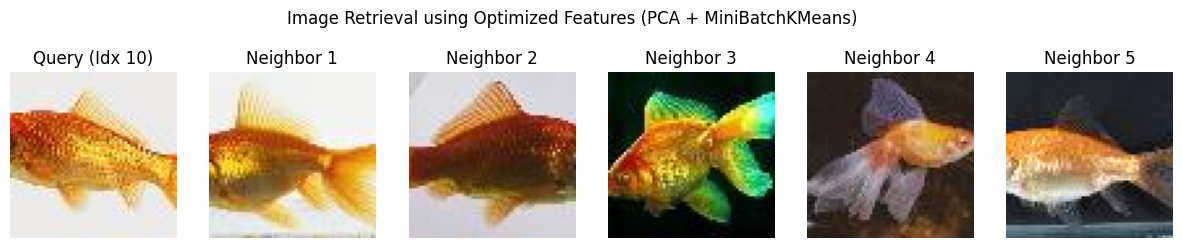

In [ ]:
# Display query and retrieved images
plt.figure(figsize=(15, 3))
titles = [f"Query (Idx {query_index})" if i == 0 else f"Neighbor {i}" for i in range(len(indices))]

for i, idx in enumerate(indices):
    plt.subplot(1, 6, i + 1)
    plt.imshow(Image.open(train_dataset.samples[idx]))
    plt.title(titles[i])
    plt.axis('off')

plt.suptitle("Image Retrieval using Optimized Features (PCA + MiniBatchKMeans)")
plt.show()

Test 2: Predicting Cluster ID for a new image (or existing sample)

In [ ]:
# test_image_path_2 = train_dataset.samples[500]

# def predict_cluster(img_path):
#     """Predicts the K-Means cluster ID for a single image."""
#     feat = extract_features(img_path)
#     cluster_id = kmeans.predict(feat)[0]
#     return cluster_id

# predicted_cluster = predict_cluster(test_image_path_2)

# print(f"\n--- Cluster Prediction Test (Index 500) ---")
# print(f"Predicted K-Means cluster for image 500: {predicted_cluster}")
# plt.imshow(Image.open(test_image_path_2))
# plt.title(f"Image 500 (Predicted Cluster: {predicted_cluster})")
# plt.axis('off')
# plt.show()

# print("\nCode execution complete. Proceed to next steps (Classifier, Hierarchical Clustering, Scaling).")


In [ ]:
print("\n--- Optional: Training SVM Classifier ---")
svm = SVC(kernel="linear", verbose=True, random_state=42)
try:
    # Train on the features (all_embeddings) and the true labels (all_labels)
    svm.fit(all_embeddings, all_labels)
    print("SVM training complete.")
    # You would typically evaluate this classifier on the validation set features (not implemented here)
    # e.g., val_embeddings, val_labels = extract_features_val_set()
    # score = svm.score(val_embeddings, val_labels)
    # print(f"SVM Accuracy on Validation Set: {score:.4f}")
except Exception as e:
    print(f"SVM training failed (may be slow or memory intensive): {e}")

9. Cluster Visualization using t-SNE

In [ ]:
print("\n--- Starting Cluster Visualization (t-SNE) ---")
# t-SNE is run on the PCA-reduced data for speed, sampling 10,000 points.

# Data Sampling
sample_size = min(10000, embeddings_for_clustering.shape[0])
np.random.seed(42)
sample_indices = np.random.choice(embeddings_for_clustering.shape[0], size=sample_size, replace=False)

sampled_embeddings = embeddings_for_clustering[sample_indices]
sampled_cluster_labels = cluster_labels[sample_indices]

tsne_start_time = time.time()
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=500,
    random_state=42,
    verbose=0,
    init='pca'
)
embeddings_2d = tsne.fit_transform(sampled_embeddings)
print(f"t-SNE reduction complete in {time.time() - tsne_start_time:.2f} seconds.")


--- Starting Cluster Visualization (t-SNE) ---


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE reduction complete in 106.27 seconds.


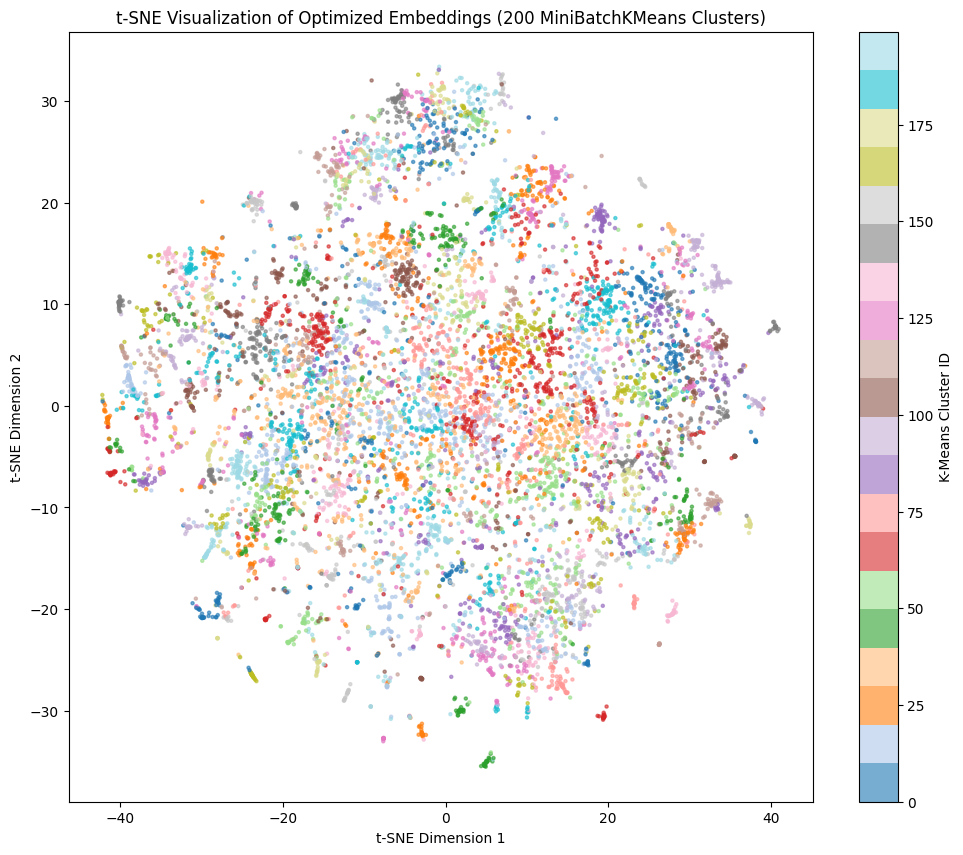


All core tasks (Feature Extraction, Clustering, Evaluation, Retrieval, Visualization) are complete.
Next steps: Implement the optional SVM classifier and Hierarchical Clustering.


In [ ]:
import pandas as pd

# Visualization Plot
tsne_df = pd.DataFrame(embeddings_2d, columns=['D1', 'D2'])
tsne_df['Cluster'] = sampled_cluster_labels

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    tsne_df['D1'],
    tsne_df['D2'],
    c=tsne_df['Cluster'],
    cmap='tab20',
    s=5,
    alpha=0.6
)

plt.title(f't-SNE Visualization of Optimized Embeddings ({k} MiniBatchKMeans Clusters)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='K-Means Cluster ID')
plt.show()

print("\nAll core tasks (Feature Extraction, Clustering, Evaluation, Retrieval, Visualization) are complete.")
print("Next steps: Implement the optional SVM classifier and Hierarchical Clustering.")

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd
import time

print("\n--- Starting Cluster Visualization (t-SNE) ---")

# --- 9.1. Data Sampling ---
# We sample 10,000 points from the 512D PCA space for fast t-SNE reduction.
sample_size = min(10000, embeddings_for_clustering.shape[0])
np.random.seed(42)
sample_indices = np.random.choice(embeddings_for_clustering.shape[0], size=sample_size, replace=False)

sampled_embeddings = embeddings_for_clustering[sample_indices]
sampled_cluster_labels_k200 = cluster_labels[sample_indices] # The original 200 clusters


--- Starting Cluster Visualization (t-SNE) ---


In [ ]:
# --- 9.2. Dimensionality Reduction using t-SNE ---
tsne_start_time = time.time()
tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=500,
    random_state=42,
    verbose=0,
    init='pca'
)
embeddings_2d = tsne.fit_transform(sampled_embeddings)
print(f"t-SNE reduction complete in {time.time() - tsne_start_time:.2f} seconds.")

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE reduction complete in 116.98 seconds.


In [ ]:
# --- 9.3. Visualization Strategy: Focus on 10 Main Groups ---
# To make the plot readable, we run a separate, simple clustering
# (Agglomerative) on the *sampled data* to find 10 high-level groups.
K_VISUAL = 10 # Only 10 colors/groups for the plot

print(f"Re-clustering sampled data into {K_VISUAL} groups just for plotting clarity...")
agg_model = AgglomerativeClustering(n_clusters=K_VISUAL, linkage='ward')
visual_labels = agg_model.fit_predict(sampled_embeddings)

Re-clustering sampled data into 10 groups just for plotting clarity...


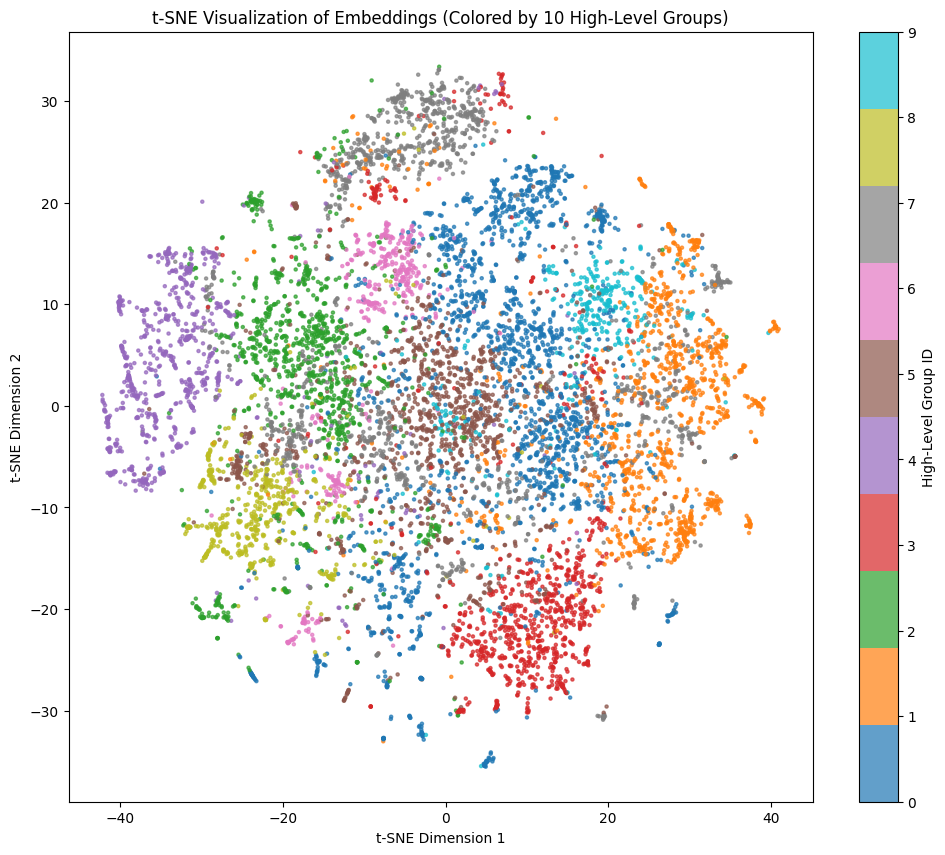


Plot displayed using 10 colors for better visibility. The underlying system still uses k=200 clusters.
All core tasks (Feature Extraction, Clustering, Evaluation, Retrieval, Visualization) are complete.
Next steps: Implement the optional SVM classifier and Hierarchical Clustering.


In [ ]:
# --- 9.4. Visualization Plot ---
tsne_df = pd.DataFrame(embeddings_2d, columns=['D1', 'D2'])
tsne_df['Visual_Cluster'] = visual_labels # Use the 10 simple cluster labels for color

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    tsne_df['D1'],
    tsne_df['D2'],
    c=tsne_df['Visual_Cluster'],
    cmap='tab10',           # Use a palette that has only 10 distinct colors
    s=5,
    alpha=0.7
)

plt.title(f't-SNE Visualization of Embeddings (Colored by {K_VISUAL} High-Level Groups)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='High-Level Group ID')
plt.show()

print(f"\nPlot displayed using {K_VISUAL} colors for better visibility. The underlying system still uses k={k} clusters.")
print("All core tasks (Feature Extraction, Clustering, Evaluation, Retrieval, Visualization) are complete.")
print("Next steps: Implement the optional SVM classifier and Hierarchical Clustering.")

# Test

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Path to Tiny ImageNet training images
train_dir = "/content/tiny-imagenet-200/train"

# Pick a class folder randomly
class_folder = os.listdir(train_dir)[0]  # first class
image_files = os.listdir(os.path.join(train_dir, class_folder))
query_image_path = os.path.join(train_dir, class_folder, image_files[0])
print("Query image path:", query_image_path)

# Display query image
plt.imshow(Image.open(query_image_path))
plt.title("Query Image")
plt.axis('off')
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
query_embedding = query_embedding.reshape(1, -1)
similarities = cosine_similarity(query_embedding, all_embeddings)[0]

# Get top-5 similar images
top_k = 5
top_indices = np.argsort(similarities)[::-1][:top_k]

# Print paths and similarity scores
print("Top similar images:")
for idx in top_indices:
    print(valid_paths[idx], " - similarity:", similarities[idx])


In [ ]:
plt.figure(figsize=(15, 5))

# Show query image
plt.subplot(1, top_k+1, 1)
plt.imshow(Image.open(query_image_path))
plt.title("Query")
plt.axis('off')

# Show retrieved images
for i, idx in enumerate(top_indices):
    plt.subplot(1, top_k+1, i+2)
    plt.imshow(Image.open(valid_paths[idx]))
    plt.title(f"Sim: {similarities[idx]:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


10. Save Artifacts for Local App

In [ ]:
import pickle
import json
import shutil

# 1. Save Embeddings (PCA reduced)
np.save('embeddings.npy', embeddings_for_clustering)

# 2. Save Filenames (Save relative paths to preserve structure and extension)
# train_dataset.root is /content/tiny-imagenet-200
# We want paths like: train/n01443537/images/n01443537_0.JPEG
root_path = train_dataset.root
if not root_path.endswith('/'):
    root_path += '/'
filenames = [f.replace(root_path, '') for f in train_dataset.samples]
with open('filenames.json', 'w') as f:
    json.dump(filenames, f)

# 3. Save PCA Model
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_model, f)

# 4. Save KMeans Model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

print("Artifacts saved locally.")

# 5. Zip them up
!zip -q artifacts.zip embeddings.npy filenames.json pca_model.pkl kmeans_model.pkl
print("Created artifacts.zip. Please download this file.")